# Notes on stochastic simulation of reactions with spatial resolution

---

Stochastic simulations are important because it provides a more detailed understanding of biology processes, e.g. reaction diffusion process. Such a description is often necessary to model biological systems where **small molecular abundances** of some chemical species make deterministic model inaccurate or even inapplicable. It is often very useful when biological phenomena depend on **stochastic fluctuations**.

## Stochastic simulation of chemical reactions lack of spatial resolution

Considering protein degradation process:
    $$A\rightarrow0$$


This reaction happens at rate $k$. The probability that one reaction happens during infinitesimal time interal $[t, t+dt)$ is given by $A(t)kdt$. We have
    $$A(t+1)-A(t) = -A(t)kdt $$
thus
    $$A(t) = A(0)e^{-kt}$$

### direct method
So we can use the following algorithm to simulate this process directly:
1. Generate a random number $r$ uniformly distributed in (0, 1)
2. If $r<A(t)kdt$, let reaction happen:  `A -= 1` , otherwise nothing changes


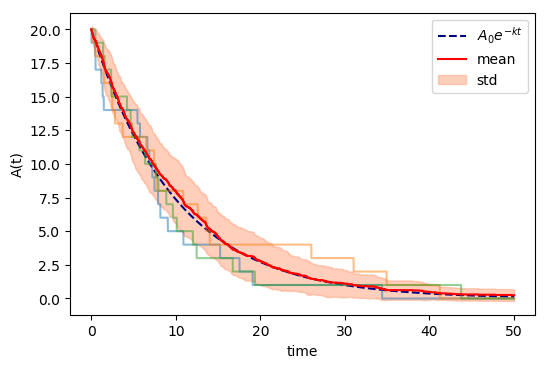

In [47]:
import numpy as np
import matplotlib.pyplot as plt

## protein degradation
## A -> 0
A0 = 20
dt = 0.005
k = 0.1

t = 50 ## simulate for 1 sec

def direct_reaction(A0, dt, k, t):
    
    ## protein degradation
    ## A -> 0
    A = A0
    tn = 0
    
    AList = []
    AList.append(A)
    while (tn<t):
        r = np.random.random()
        if (r < A*dt*k):
            A -= 1
        AList.append(A)
        tn += dt
    return AList

def plot_num(ALists, tList, y=0, note="", mloc=0, ylabel="A(t)"):
    ALists = np.asarray(ALists)
    mean = np.mean(ALists, axis=0)
    std = np.std(ALists, axis=0)
     # 100 linearly spaced numbers

    fig, ax= plt.subplots(figsize=(6,4), dpi=100)
    try:
        plt.plot(tList, y, '--',color='navy', label=note)
    except: y==0
    
    for i in range(3):
        plt.plot(tList, ALists[i], alpha=.5)
    plt.plot(tList, mean,'r', label="mean")
    plt.fill_between(tList, mean-std, mean+std, color='lightsalmon',alpha=.5, label="std")
    plt.legend(loc=mloc)
    plt.xlabel('time')
    plt.ylabel(ylabel)
    plt.show()
    return

manyRun = []
for i in range(50):
    manyRun.append(direct_reaction(A0, dt, k, t))
    
tList = np.linspace(0,t,len(manyRun[0]))
y = A0*np.exp(-k*tList)


plot_num(manyRun, tList, y, "$A_0e^{-kt}$")



To get reasonable accurate results, we have to assume $A(t)kdt\ll0$ which makes condition `if (r<A*k*dt)` very hard to be satisfied. As a result, during most of the time steps, we generate lots of and find nothing occurs during that time. Therefore, we need to design a more efficient method.

### Gillespie algorithm

Assume at time t, there are $A(t)$ molecules in the system. We want to know when the next reaction happens. Denote $P(t, \tau)dt$ as the probablity that the next reaction will take place at time $[t+\tau, t+\tau+dt)$ given the current state $A(t)$. It requires two steps,

* until time $t+\tau$, no reaction happens. Let $P_0(t, \tau)$ be the probability that no reaction happens durint $(t, t+\tau)$
* in infinitesimal time interval $[t+\tau, t+\tau+dt)$, an reaction takes place, the probability is $A(t)kdt$

Then
    $$P(t, \tau) = P_0(t, \tau)\ A(t)kdt$$

To compute $P_0(t, \tau)$, we consider the probability that no reaction happens till time $t+\tau+dt$
    $$P_0(t, \tau+dt) = P_0(t, \tau)(1-A(t)kdt)$$
    
Taking $dt\rightarrow0$, this can be solved analytically, which is:
    $$P_0(t, \tau) = P_0(t, 0)e^{-A(t)k\tau}$$
    
Obviously $P_0(t, 0)=1$. Therefore, $P(t, \tau)$ can be written as
    $$P(t,\tau)dt = A(t)ke^{-A(t)k\tau}dt$$

Now we know the distribution of time $\tau$, which is an exponential distribution. Next question is how we can generate such distribution. Let's consider function $F(\tau)=e^{-kA(t)\tau}$. We will show that if $\tau$ is a random number satisfying exponential distribution then $F(\tau)$ is a random number uiformly distributed between 0 and 1. In fact, the probability that $F(\tau)\in (a, b)$ is equal to the probability that $\tau\in(F^{-1}(a), F^{-1}(b))$, which is given by
    $$
    \int_{F^{-1}(a)}^{F^{-1}(b)}P(t, s)ds =  \int_{F^{-1}(a)}^{F^{-1}(b)}Ake^{-Aks}ds = -\int_{F^{-1}(a)}^{F^{-1}(b)}\frac{dF}{ds}ds =b-a 
    $$
    
We now know that $F(\tau)$ is a random number uniformly distributed in (0, 1). Hence we can first generate a unform random number $r$ between (0, 1) and compute $\tau$ using 
    $$\tau = \frac{1}{A(t)k}\ln(\frac{1}{r})$$

For system with more than one reaction, $P_0(t, \tau)$ has to be modified into 
    $$P_0(t, \tau+dt) = P_0(t, \tau)(1-\sum_{i}a_i(t)dt)$$
where $a_i(t)=h_i(t)c_i$ is the propensity function for i'th reaction, $h_i(t)$ denotes how many molecule pairs of reactant for reaction i at time t and $c_i$ is the rate of that reaction. Conseqently
    $$P_\mu(t, \tau)dt = a_\mu e^{-\sum_ia_i\tau}=a_\mu e^{-a_0\tau} = \frac{a_\mu}{a_0}\times a_0e^{-a_0\tau}dt$$
gives the probability that next reaction takes place at time $[t+\tau, t+\tau+dt)$ and it will be reaction $\mu$

## examples

Let's consider reaction 
$$A\xrightarrow{k_1} 0\: \text{and}\: 0\xrightarrow{k_2} A$$

The algrithum is
```
1. generate two random nunmbers r1, r2
2. compute propensity function a1=A(t)*k1, a2=k2, thus a0 = a1+a2 = A(t)*k1+k2
3. compute the time tau = -log(r1)/a0
4. deremine the reaction type
    if r2< a1/(a1+a2), A(t) -= 1
    else A(t) += 1
5. update the system and go to 1
```


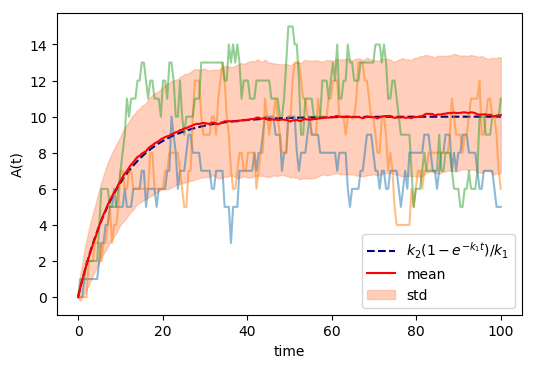

In [35]:
import numpy as np
import matplotlib.pyplot as plt

## protein degradation and production
## A -> 0, k1
## 0 -> A, k2
A0 = 0
k1 = 0.1
k2 = 1.0

t = 100 ## simulate for 50 sec
dT = 0.5 ## time interval between two measurement

def gillespie_example(A0):
    
    ## protein degradation and production
    ## A -> 0, k1
    ## 0 -> A, k2
    A = A0
    tn = 0
    dTn = 0
    
    AList = []
    tList = []
    AList.append(A)
    a2 = k2     ## a2 doesn't change
    while (tn<t):
        r1 = np.random.random()
        r2 = np.random.random()
        
        a1 = A*k1
        a0 = a1+a2
        
        tn += -np.log(r1)/a0  # detemine the time
        
        if (r2 < a1/a0):    # detemine the next reaction
            A -= 1
        else:
            A += 1
        tList.append(tn)
        AList.append(A)
    return tList, AList

def synchro(tList, AList, dT, T):
    ### synchronize the evolution list
    tn = 0
    AList_new = [] 
    ti = 0
    maxLen = len(tList)
    
    while (tn<T):
        if (tn<tList[ti]):
            AList_new.append(AList[ti])
            tn += dT
        else:
            ti += 1
    return AList_new

manyRun = []
for i in range(1000):
    tList, Alist = gillespie_example(A0)
    manyRun.append(synchro(tList, Alist, dT, t))

tList = np.linspace(0,t,len(manyRun[0]))
y = k2/k1*(1-np.exp(-k1*tList))

plot_num(manyRun, tList, y, "$k_2(1-e^{-k_1t})/k_1$", mloc=4)

On the other hand, we can get analytical results from Master equation. Let $p_n(t)$ denotes the probability that $A(t)=n, n=1, 2, 3...$. Then
$$\frac{dP_n}{dt}=k_1(n+1)P_{n+1}+k_2P_{n-1}-(k_1n+k_2)P_n$$

The stochastic mean $M(t)$ and variance $V(t)$ are
    $$M(t) = \sum_{n=0}^{\infty} nP_n(t)$$
    $$V(t) = \sum_{n=0}^{\infty} (n-M(t))^2P_n(t)=\sum_{n=0}^{\infty}n^2P_n(t)-M^2(t)$$

Therefore, the evolution function for $M(t)$ is
$$
\frac{dM(t)}{dt}=\sum_{n=0}^{\infty} n\frac{dP_n}{dt}=k_1\sum_{n=0}^{\infty}n(n+1)P_{n+1}+k_2\sum_{n=1}^{\infty}nP_{n-1}-k_1\sum_{n=0}^{\infty}n^2P_n-k_2\sum_{n=0}^{\infty}nP_n
$$

Effectively $\sum_{n=0}^{\infty}n(n+1)P_{n+1}=\sum_{n=0}^{\infty}(n-1)nP_n$ and $\sum_{n=1}^{\infty}nP_{n-1}=\sum_{n=0}^{\infty}(n+1)P_n$. We get
$$
\frac{dM(t)}{dt}=-\sum_{n=0}^{\infty}k_1nP_n+k_2\sum_{n=0}^{\infty}P_n=-k_1M(t)+k_2
$$

Solving this with initial condition $M(0)=0$ gives
    $$M(t)=\frac{k_2}{k_1}(1-e^{-k_1t})$$

Similar calcuation for $V(t)$ gives
    $$\frac{dV}{dt}=-2k_1V+k_1M+k_2$$

Fixed point: $M_s=V_s=k_2/k_1$. So we get the standard deviation is the square root of the system size, as expected.
    $$\sigma=\sqrt{M_s}$$

Additionally, we are interested in the stationary distribution
$$\phi(n)=\lim_{t\rightarrow\infty}P_n(t)$$
That means $dP_n(t)/dt=0$. Using the recurence we can compute $\phi(n)$ exactly.
$$
\phi(n)=\frac{1}{n!}(\frac{k_2}{k_1})^ne^{-\frac{k_2}{k_1}}
$$

We can compare this with the results from simulations.

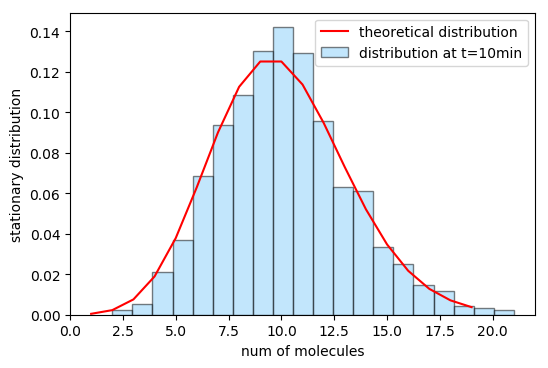

In [38]:
finalState = []
for i in range(1000):
    finalState.append(manyRun[i][-1])

def plot_pdf(data, x=0, y=0, mlab="", num_bins=20, xlabel="num of molecules", ylabel="stationary distribution"):
    fig, ax = plt.subplots(figsize=(6,4), dpi=100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    n, bins, patches = plt.hist(data, num_bins, normed=1,facecolor='lightskyblue', alpha=0.5, ec='black', label="distribution at t=10min")
    try:
        plt.plot(x, y, '-r', label="theoretical distribution")
    except: x==0
    plt.legend(loc=0)
    plt.show()
    return



def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
nList = np.arange(1, 20)
phi = np.array([pow(k2/k1, i)*np.exp(-k2/k1)/factorial(i) for i in nList])

plot_pdf(finalState, nList, phi)

## Stochastic Simulation of Diffusion

The trajectory of a molecule inside a living cell executes a random walk since it keeps bump into other molecules, which serves as a starting point of our simulation of diffusion process.

### Smoluchowski equation and diffusion.

Starting from position $x(0)$, we want to know the position at time $t$, $x(t)$. Based on the Einstein's theory about random walk, for one dimension space, we have
$$<R^2(t)>=2Dt$$

Thus, the evolution of coordinates x is given by
$$x(t+dt)=x(t)+\sqrt{2Ddt}\xi$$
where $D$ is the diffusion constant and $\xi$ is a normally distributed random number (with zero mean and unit variance).


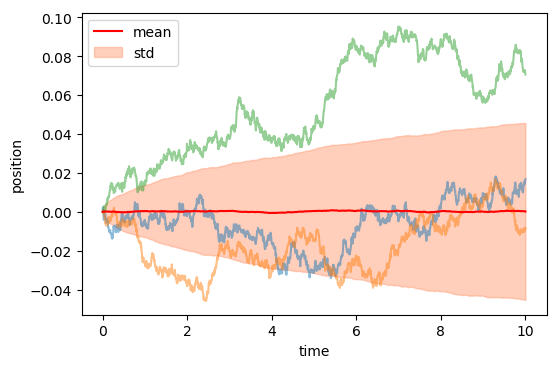

In [48]:
## diffusion of protein in a cell
import numpy as np


D = 0.0001 # mm^2/sec
dt = 0.005 # time interval
x0 = 0

t = 10 # simulate for 10sec

def diffusion(x0):
    x = x0
    xList = []
    xList.append(x)
    tn = 0
    c = np.sqrt(2*D*dt)
    while (tn<t):
        r = np.random.normal()
        x += c*r
        tn += dt
        xList.append(x)
    return xList

manyRun = []
for i in range(1000):
    manyRun.append(diffusion(x0))
    
tList = np.linspace(0, t, len(manyRun[0]))

plot_num(manyRun, tList, ylabel="position")


Let $\phi(x)dx$ be the probability the partical is in $[x, x+dx)$. Then the process corrosponds to the diffusion equation
$$\partial_t\phi(x)=D\partial^2_x\phi(x)$$
This can be solved with the initial condition $\phi(0)=\delta(x)$, which is 
$$\phi(x)=\frac{1}{\sqrt{4D\pi t}}e^{-\frac{x^2}{4Dt}}$$
We can use this to verify our simulation

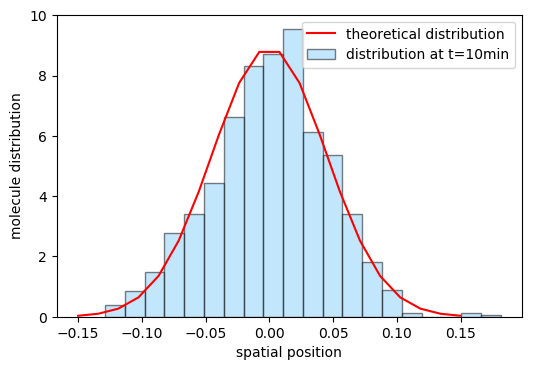

In [49]:
finalState = []
for i in range(1000):
    finalState.append(manyRun[i][-1])
    
t = 10
xList = np.linspace(-0.15, 0.15, 20)
phi = np.array([np.exp(-x*x/(4*D*t))/np.sqrt(4*D*3.1416*t) for x in xList])

plot_pdf(finalState, xList, phi, xlabel="spatial position", ylabel="molecule distribution")

### Compartment based approach to diffusion

We divide the computational domain $[0, L]$ into $K=40$ compartments. So each compartment's length is $h=L/K$. The diffusion can be described as a "chain of chemical reactions"
$$A_1 \rightleftarrows A_2,\; A_2\rightleftarrows A_3, ... \;, A_{K-1}\rightleftarrows A_{K}$$
where $A_i$ is the number of molecules in i'th compartment and the rate of each reaction is $d$. Then Gillespie algoritum can be used to simulate thoes processes. We show that this provides a correct model of diffusion if $d=D/h^2$. (The detaied prove can be found [here][1]). 
[1]: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.71.041103


Let $p(\pmb{n}, t)$ be the probability that the system is in state $\pmb{n}=[n_1, n_2, ..., n_K]$. Let's define two operator $R_i$ and $L_i$:
$$R_i:[n_1,n_2,...,n_K]\rightarrow [n_1,...,n_{i}+1, n_{i+1}-1,...n_K]$$
$$L_i:[n_1,n_2,...,n_K]\rightarrow [n_1,...,n_{i-1}-1, n_i+1,...n_K]$$
Then the master equation of reactions above is 
$$\frac{\partial P(\pmb{n})}{\partial t}=d\sum_{j=1}^{K-1}((n_j+1)P(R_j\pmb{n})-n_jP(\pmb{n}))+d\sum_{j=2}^K((n_j-1)P(L_j\pmb{n})-n_jP(\pmb{n}))$$

The mean is defined as the vector $\pmb{M}=[M_1, M_2,..., M_K]$ where
$$M_i(t)=\sum_{\pmb{n}}n_iP(\pmb{n, t})=\sum_{n_1=0}^{\infty}\sum_{n_2=0}^{\infty}...\sum_{n_K=0}^{\infty}n_iP(\pmb{n}, t)$$

So the evolution of mean value $M_i$ is
$$\frac{\partial M_i}{\partial t}=\sum_{\pmb{n}}n_i\frac{\partial P(\pmb{n})}{\partial t}=d\sum_{\pmb{n}}n_i\{\sum_{j=1}^{K-1}[(n_j+1)P(R_j\pmb{n})-n_jP(\pmb{n})]+\sum_{j=2}^K[(n_j-1)P(L_j\pmb{n})-n_jP(\pmb{n})]\}$$


We can simplify this equation and get:
$$\frac{\partial M_i}{\partial t}=d(M_{i+1}+M_{i-1}-2M_i)$$

Relating this to the diffusion equation
$$\frac{\partial \rho}{\partial t}=D\nabla^2\rho\approx D\frac{(\rho_{i-1}+\rho_{i+1}-2\rho_i)}{h^2}$$ 
We get

$$d=\frac{D}{h^2}$$

In the following we simulate the diffusion of 1000 particals and compare the results with the analytical formular:
$$\phi(x)=\frac{1}{\sqrt{4D\pi t}}e^{-\frac{x^2}{4Dt}}$$

In [4]:
# ------------------------------------
# purely diffusion
# -------------------------------------
# A, i from 0-100

# --diffusion:
# R0: A[i] -> A[i-1]                 d
# R1: A[i] -> A[i+1]                 d

# [A[i]]
import numpy as np
#import matplotlib as plt
import gillespieNRM as nrm
import importlib as imp

L = 0.3
h = 0.015
nSites = int(L/h)    #20
nRxn = 2
nSpec = 1

#define all the reactions on single sites
subst = np.zeros((nRxn, nSpec*nSites), dtype=int)
prods = np.zeros((nRxn, nSpec*nSites), dtype=int)

subst[0, 0] = -1
prods[0, nSites-1] = 1

subst[1, 0] = -1
prods[1, 1] = 1

stoch_subst, stoch_prods = nrm.extendReaction(subst, prods, nRxn, nSpec, nSites)
stoch = stoch_subst + stoch_prods
depGraph = nrm.buildDepGraph(nRxn, nSites, nSpec, stoch, stoch_subst)

D = 1E-4
d = D/h**2

sRates = [d, d]
rates = nrm.extendRates(sRates, nRxn, nSites)

init = np.zeros((nSpec, nSites), dtype=int)
n0 = 1000
init[0,int(nSites/2)] = n0
init = np.reshape(init, nSpec*nSites)

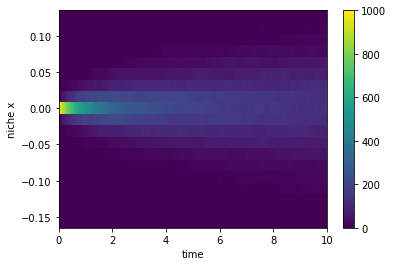

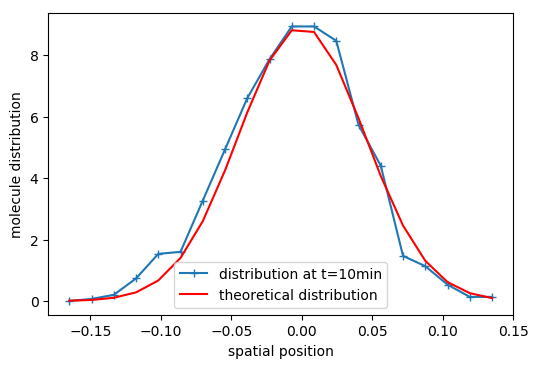

In [8]:
tmax = 10
nrmax = 60000
dT = 0.1

store_t2, store_mols2, store_r2 = nrm.gillespieNRM(init, rates, stoch_subst, stoch_prods, depGraph, tmax, nrmax)

#plotPop(store_t2, store_mols2, store_r2, nSites)
nrm.plotDen2(store_t2, store_mols2, nSites)

norm =  float(nSites)/(L*n0)
nrm.plotDen(store_t2, np.multiply(store_mols2, norm), nSites)

## Stochastic reaction diffusion model

In this section we add chemical reactions to models with diffusion. Let's consider the molecule A diffuse at domain $[0, L]$ with $L=1mm$ diffusion constant $D=0.0001mm^2/sec$ and can be produced in domain $[0, L/5]$ with rate $k_p=0.012 \mu m^{-1}sec^{-1}$. That means in the probability that a molecule is created somewhere in the interval $[0, L/5]$ is equal to $k_pL/5dt$. Besides, they degrades at constant rate $k_1=10^{-3}sec^{-1}$. Initially there is no molecule in system and zero-influx boundary condition is used in the model.

We divide the domain into $K=40$ compartments. The reactions are
$$A_1 \rightleftarrows A_2,\; A_2\rightleftarrows A_3, ... \;, A_{K-1}\rightleftarrows A_{K}$$
$$A_i\xrightarrow{k_1}0\;\text{for i=1,2,..., K}$$
$$0\xrightarrow{k_2}A_i\; \text{for i =1,2,...,K/5}$$

the reaction for the diffusion has reaction rate $d=D/h^2$ where $h=L/K$. As for the production rate, $k_2=k_ph$.


In [25]:
# ------------------------------------
# reaction diffusion
# -------------------------------------
# A, i from 0-40

# --diffusion:
# R0: A[i] -> A[i-1]       d     i=2,..,K
# R1: A[i] -> A[i+1]       d     i=1,2,...,K-1
# R2: A[i] -> 0            k1    i=1,2,....,K
# R3: 0->A[i]              k2    i=1,2,...,K/5

# zero influx bc

import numpy as np
#import matplotlib as plt

L = 1.0
h = 0.025
nSites = int(L/h)    #40
nRxn = 4
nSpec = 1

#define all the reactions on single sites
subst = np.zeros((nRxn, nSpec*nSites), dtype=int)
prods = np.zeros((nRxn, nSpec*nSites), dtype=int)

subst[0, 1] = -1
prods[0, 0] = 1

subst[1, 0] = -1
prods[1, 1] = 1

subst[2, 0] = -1

prods[3, 0] = 1

#stoch_subst, stoch_prods = nrm.extendReaction(subst, prods, nRxn, nSpec, nSites)
def shiftRight(a, n):
    if n==0: return a
    n = n % nSites
    b = np.copy(a)
    b = np.reshape(b, (nSpec, nSites))
    for i in range(nSpec):
        b[i] = np.roll(b[i], n)
    return np.reshape(b, nSpec*nSites)

nRxnTot = nSites*nRxn-4*nSites//5-2

stoch_subst = np.zeros((nRxnTot, nSpec*nSites), dtype=int)
stoch_prods = np.zeros((nRxnTot, nSpec*nSites), dtype=int)
for i in range(2):
    for j in range(nSites-1):
        stoch_subst[i*(nSites-1)+j] = shiftRight(subst[i], j)
        stoch_prods[i*(nSites-1)+j] = shiftRight(prods[i], j)
## 39*2 = 78
i = 2
for j in range(nSites):
    stoch_subst[i*(nSites-1)+j] = shiftRight(subst[i], j)
    stoch_prods[i*(nSites-1)+j] = shiftRight(prods[i], j)  
## 78+40 = 118

i = 3
for j in range(nSites//5):
    stoch_subst[i*nSites-2+j] = shiftRight(subst[i], j)
    stoch_prods[i*nSites-2+j] = shiftRight(prods[i], j)
## 118+8 = 126  

stoch = stoch_subst + stoch_prods

depGraph = []
for i in range(nRxnTot):
    tmp = []
    tmp.append(i)
    for j in range(nSpec*nSites):
        if stoch[i, j]!=0:
            for k in range(nRxnTot):
                if k!=i and stoch_subst[k, j]!=0:#tmp.append(k)
                    if not (k in tmp):tmp.append(k)
    depGraph.append(tmp)

D = 1E-4
d = D/h**2
k1 = 1E-3
kp = 0.012
k2 = kp*h*1E3
sRates = [d, d, k1, k2]
rates = np.zeros(nRxnTot)
for i in range(2):
    for j in range(nSites-1):
        rates[i*(nSites-1)+j] = sRates[i]
i = 2
for j in range(nSites):
    rates[i*(nSites-1)+j] = sRates[i]

i = 3
for j in range(nSites//5):
    rates[i*nSites-2+j] = sRates[i]
    
init = np.zeros((nSpec, nSites), dtype=int)
#n0 = 1000
#init[0,int(nSites/2)] = n0
init = np.reshape(init, nSpec*nSites)

In [19]:
import importlib as imp
import stochsim as sts
import numpy as np

<module 'stochsim' from '/Users/skyhd/Documents/python/gillespie/gillespieSpatial/stochsim.py'>

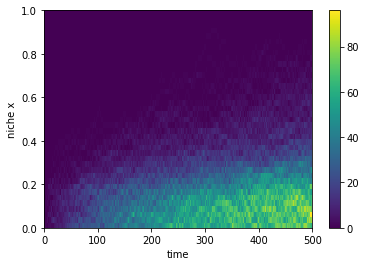

In [21]:
usa = sts.Stoch(nSites, nRxn, nSpec)
usa.setup(stoch_subst, stoch_prods, rates)
tmax = 500
nrmax = 60000
t2, mols2, r2 = usa.run(init, tmax, nrmax)
sts.plotDen2(t2, mols2, nSites)

The corresponding master equation is 
$$
\frac{\partial P(\pmb{n})}{\partial t}=d\sum_{i=1}^{K-1}[(n_i+1)P(R_i\pmb{n})-n_iP(\pmb{n})]+d\sum_{i=2}^{K}[(n_i+1)P(L_i\pmb{n})-n_iP(\pmb{n})]\\+k_1\sum_{i=1}^{K}[(n_i+1)P(n_1,n_2,...,n_i+1,...n_K)-nP(\pmb{n})]+k_2\sum_{i=1}^{K/5}[P(n_1,n_2,...,n_i-1,...n_K)-P(\pmb{n})]
$$

Multiplying by $n_i$ and sum over all $n_j, j=1,...,M$ we obtain the mean field equation
$$
\partial_tM_1=d(M_2-M_1)-k_1M_1+k_2\\
\partial_tM_i=d(M_{i+1}+M_{i-1}-2M_i)-k_1M_i+k_2\;\;\; i=1,2,...,K/5\\
\partial_tM_i=d(M_{i+1}+M_{i-1}-2M_i)-k_1M_i\;\;\; i=K/5+1,...,K-1\\
\partial_tM_{K}=d(M_{K-1}-M_K)-k_1M_K
$$
which is a discretized diffusion reaction equation:
$$
\partial_ta=D\partial_x^2a+k_2\chi_{[0,L/5]}-k_1a
$$
with zero-flux boundary condition.

In [22]:
import importlib as imp
import pdeSolver as pde

Lx=100
Nt = 5000
dt = tmax/Nt

def init():
    u0 = np.array([0.0 for i in range(Lx)])
    v0 = np.array([0.0 for i in range(Lx)])
    return u0, v0
    
def func(u, v):
    reac_u = np.multiply(-k1*dt, u)
    for i in range(Lx//5):
        reac_u[i] += k2*dt
    reac_v = np.array([0.0 for i in range(Lx)])
    return reac_u, reac_v

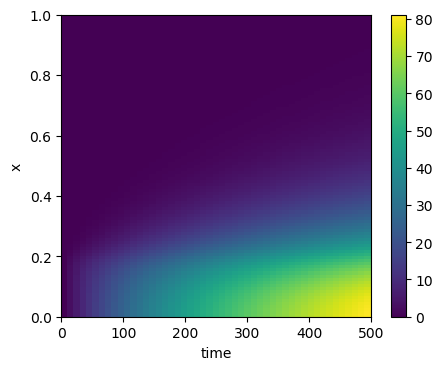

In [23]:
imp.reload(nrm)
rec1 = pde.Pde(D, 0, t=tmax, Nt=Nt, bc=2, Nx=Lx)
rec1.init(init)
u, v = rec1.solve(func)
rec1.plotDen()

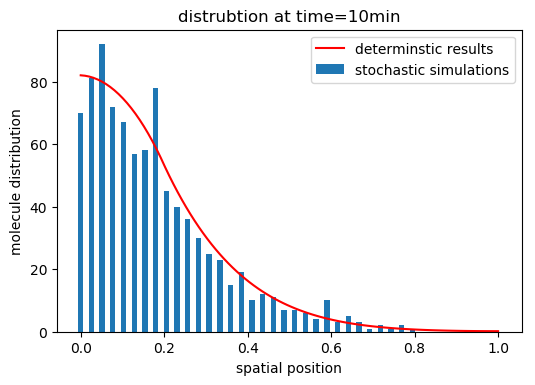

In [74]:
import matplotlib.pyplot as plt
fig, ax= plt.subplots(figsize=(6,4), dpi=100)

xList = np.linspace(0, 1, nSites)
x = np.linspace(0, 1, Lx)

width = np.min(np.diff(xList))/2
plt.title("distrubtion at time=10min")
plt.bar(xList, mols2[-1, :], width, label="stochastic simulations", align='center')
plt.plot(x, u[-1], '-r', label="determinstic results")
plt.xlabel("spatial position")
plt.ylabel("molecule distribution")
plt.legend(loc=0)

plt.show()

## Reaction-diffusion SSA based on the Smoluchowski equation

We use random walking framework to simulate the diffusion reaction processes. Taking the same example, we do simulation using the following steps:
1. For each molecule, computing it's new position at time t+dt using random walk equation
2. For each molecule, generate a random number r1 that is uniformly distributed in [0, 1], if `r1<k1*dt`, then remove that molecule
3. Generate a random number r2 uniformly distribued in [0, 1], if `r2<kp*dt*L/5`, then generate another random number r3 and introduce a new molecule at position r3*L/5

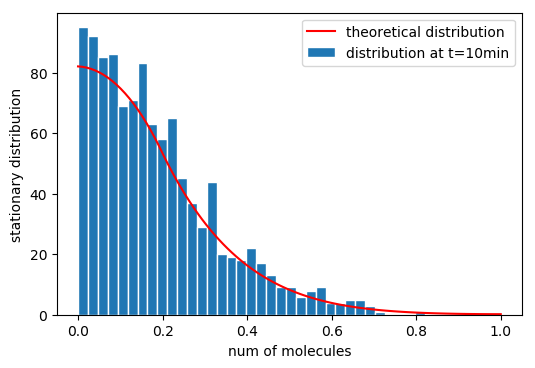

In [83]:
import numpy as np
#import matplotlib as plt
import importlib as imp

L = 1.0
D = 1E-4
t = 10.0
k1 = 1E-3
kp = 12.0
k2 = kp*h*1E3

def diffusion_reaction(D, tmax=1.0, dt=0.02):
    num = 0
    mList = []
    k1dt = k1*dt
    k2dt = kp*dt*L/5
    c = np.sqrt(2*D*dt)
    class mol:
        def __init__(self, x0):
            self.x = x0
            self.alive = True
            
        def go_die(self):
            self.alive = False
        
        def diff(self):
            self.x += c*np.random.normal()
            if self.x<0:
                self.x = abs(self.x)
            elif self.x>L:
                self.x = 2*L-self.x
        def is_alive(self):
            return self.alive
        
        def getx(self):
            return self.x

    tn = 0
    while (tn<tmax):   
        for m in mList:
            r1 = np.random.random()
            if r1<k1dt:
                m.go_die()
            else:
                m.diff()
        r2 = np.random.random()
        if r2<k2dt:
            r3 = np.random.random()
            m = mol(r3*L/5)
            mList.append(m)
        
        n = len(mList)
        i = 0
        while (i<n):
            if not mList[i].is_alive():
                del mList[i]
                n -= 1
            else:
                i += 1
        tn += dt
    xList = []
    for m in mList:
        xList.append(m.getx())
    return xList

        
#xList = diffusion_reaction(D, tmax=600)

def plot_pdf(data, x=0, y=0, mlab="", num_bins=40, xlabel="num of molecules", ylabel="stationary distribution"):
    fig, ax = plt.subplots(figsize=(6,4), dpi=100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    width = 0.2/40
    n, bins, patches = plt.hist(data, num_bins, ec='w', label="distribution at t=10min")
    try:
        plt.plot(x, y, '-r', label="theoretical distribution")
    except: x==0
    plt.legend(loc=0)
    plt.show()
    return

x = np.linspace(0, 1, Lx)
plot_pdf(xList, x, y=u[-1])

## Reaction diffusion system of nonlinear chemical kinetics.


Nonlinear chemical systems have second order reaction which requires two molecules collide and react with each other. The generalization of Smoluchowski equation based SSA is not a trivial problem. We will get to this later. However, the application of Gillespie algorithm is more strightforward.